Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Deep_learning/Data_set/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Deep_learning/Data_set/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Data Visualization

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2,
                                                                                subset="training",
                                                                                seed=123,
                                                                                image_size=(img_height, img_width),
                                                                                batch_size=batch_size)    

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2,
                                                                              subset="validation",
                                                                              seed=123,
                                                                              image_size=(img_height, img_width),
                                                                              batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
# This will yield batches of images from the subdirectories present in the particular path.

image_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

Found 6739 files belonging to 9 classes.


In [ ]:
# Seeing all the class names 
img_cls_names = image_ds.class_names
img_cls_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
# Let's store all the images in a dictionary with their name as a key for dict
img_dict = {}
for i in img_cls_names:
    img_dict[i] = list(map(lambda IMG:str(data_dir_train)+"/"+i+"/"+IMG,os.listdir(str(data_dir_train)+'/'+i)))

In [ ]:
# See the number of images in each classes

for i in img_cls_names:
  print("Number of images in " + i + " are " + str(len(img_dict[i])))

Number of images in actinic keratosis are 115
Number of images in basal cell carcinoma are 377
Number of images in dermatofibroma are 96
Number of images in melanoma are 439
Number of images in nevus are 358
Number of images in pigmented benign keratosis are 463
Number of images in seborrheic keratosis are 78
Number of images in squamous cell carcinoma are 182
Number of images in vascular lesion are 140


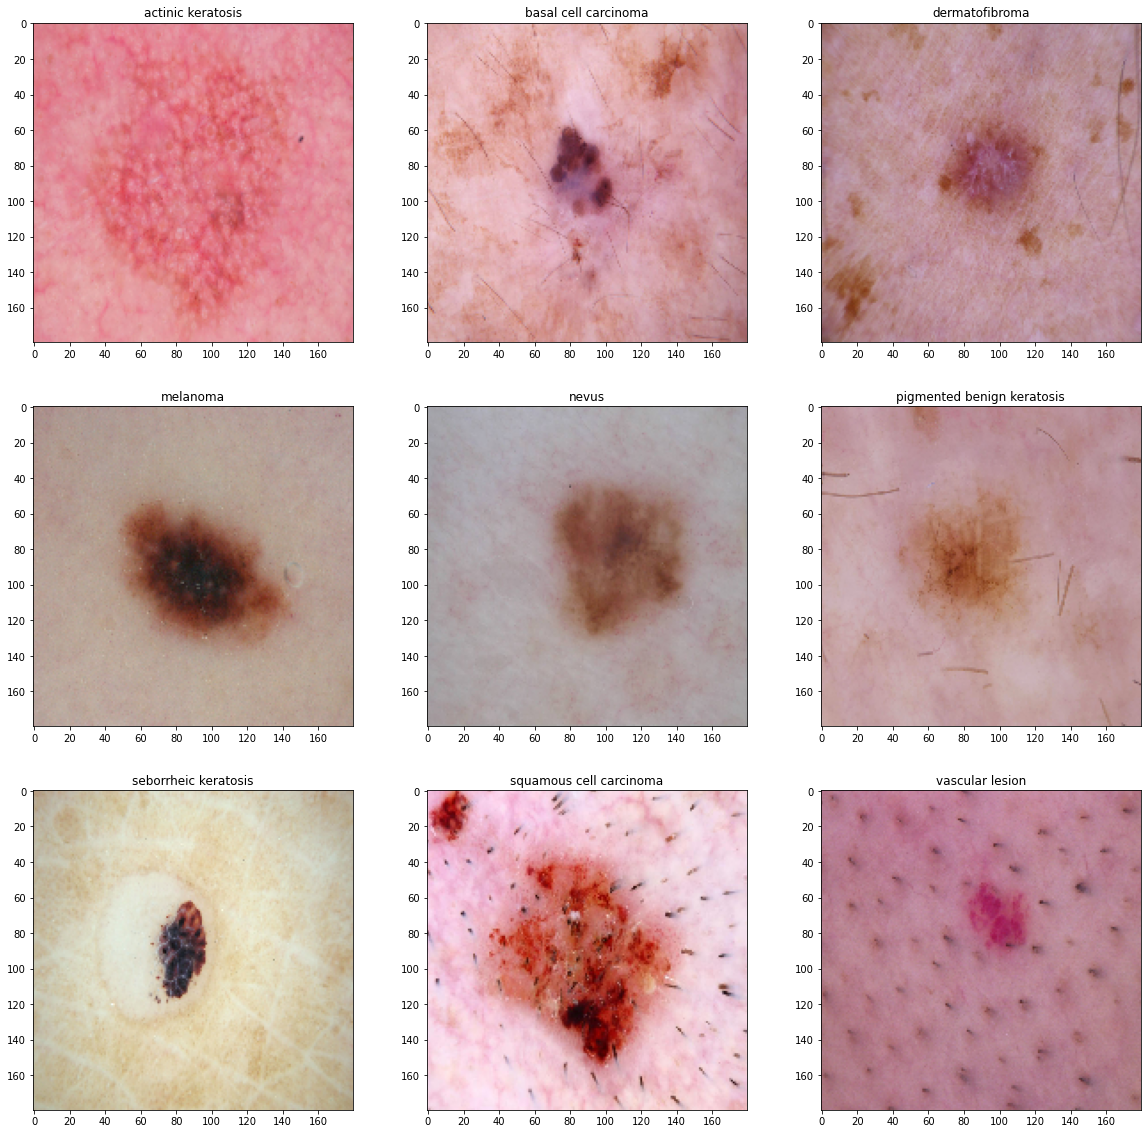

In [ ]:
# importing load_img from keras to visualize
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Let's display any one image of all the classes
plt.figure(figsize=(20,20))
count = 0
for i in img_cls_names:
    link = img_dict[i][0:1]
    count += 1
    plt.subplot(3,3,count)
    plt.imshow(load_img(link[0],target_size=(180,180)))
    plt.title(i)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


preprocessing_layers = [tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))]

input_shape = (180,180,3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  batch_size = 32,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 45s 109ms/step - loss: -1335243.6250 - accuracy: 0.1339 - val_loss: -3993345.2500 - val_accuracy: 0.1151
Epoch 2/20
169/169 [==============================] - 12s 70ms/step - loss: -17519006.0000 - accuracy: 0.1337 - val_loss: -29276524.0000 - val_accuracy: 0.1151
Epoch 3/20
169/169 [==============================] - 12s 70ms/step - loss: -69751104.0000 - accuracy: 0.1337 - val_loss: -91436496.0000 - val_accuracy: 0.1151
Epoch 4/20
169/169 [==============================] - 12s 70ms/step - loss: -178142304.0000 - accuracy: 0.1337 - val_loss: -217688096.0000 - val_accuracy: 0.1151
Epoch 5/20
169/169 [==============================] - 12s 70ms/step - loss: -358194432.0000 - accuracy: 0.1337 - val_loss: -563075264.0000 - val_accuracy: 0.1151
Epoch 6/20
169/169 [==============================] - 12s 70ms/step - loss: -620008640.0000 - accuracy: 0.1337 - val_loss: -620105088.0000 - val_accuracy: 0.1151
Epoch 7/20
169/169 [===============

### Visualizing training results

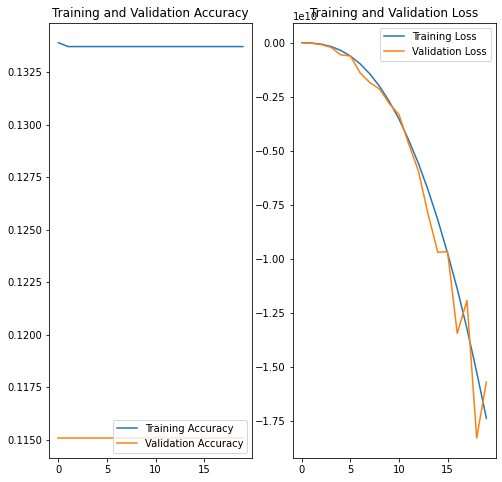

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy )
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 17ms/step - loss: -15705842688.0000 - accuracy: 0.1151
Accuracy:  0.1337166130542755
Validation Accuracy:  0.11507052928209305
Loss:  -15397679104.0
Validation Loss -15705842688.0


Here, we can say that the model is overfitting

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


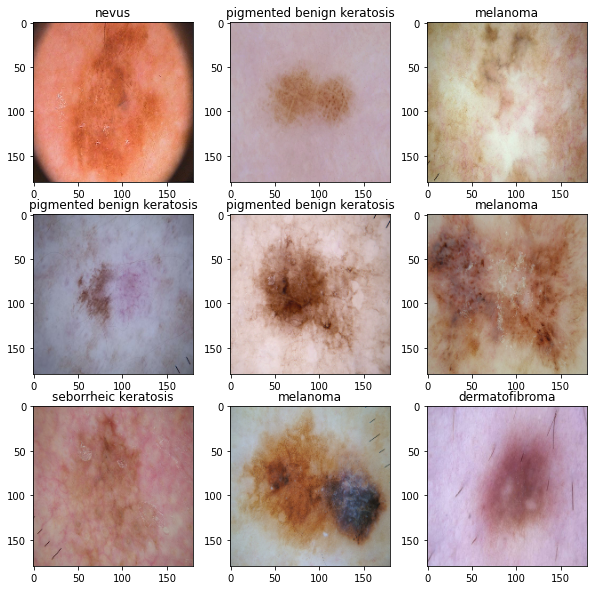

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()

# Incresing our model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Add Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

### Compiling the model

In [ ]:
## Your code goes here
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Training the model

In [ ]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(train_batches, epochs = 20, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
38/38 [==============================] - 72s 2s/step - loss: 39.9190 - accuracy: 0.3979 - val_loss: 1.6583 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 64s 2s/step - loss: 1.0069 - accuracy: 0.4791 - val_loss: 1.5422 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 66s 2s/step - loss: 0.9062 - accuracy: 0.5586 - val_loss: 1.2934 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 64s 2s/step - loss: 0.8050 - accuracy: 0.6297 - val_loss: 1.1976 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 64s 2s/step - loss: 0.7733 - accuracy: 0.6544 - val_loss: 1.2100 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 6/20
38/38 [==============================] - 64s 2s/step - loss: 0.7757 - accuracy: 0.6494 - val_loss: 1.1540 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/20
38/38 [==============================] - ETA: 0s - loss: 0.7861 - accu

### Visualizing the results

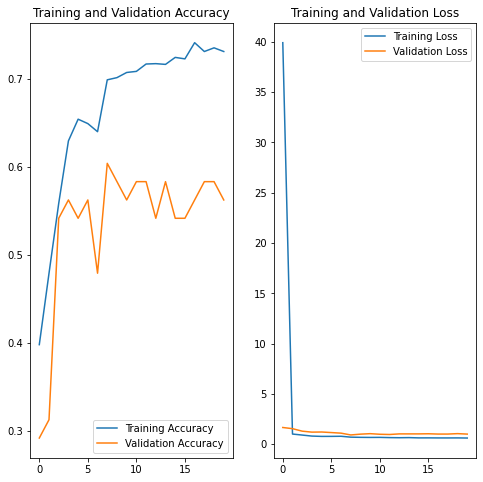

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run? Yes, It improved

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

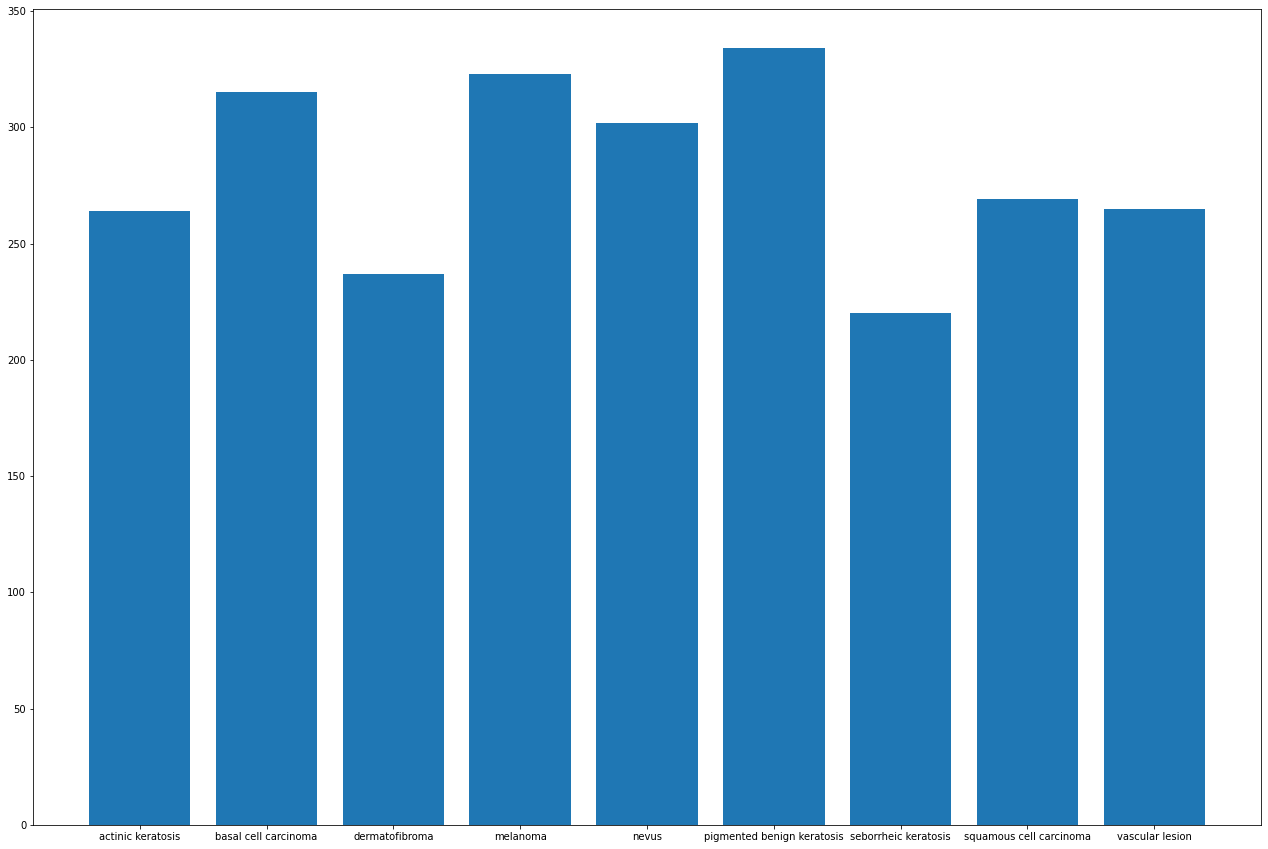

In [ ]:
data = {}

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(22)
f.set_figheight(15)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? **Dermatofibroma, Seborrheic keratosis and actinic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? **Pigmented benign keratosis and Melanoma**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Deep_learning/Data_set/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3B319EF50>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3D4351550>: 100%|██████████| 500/500 [00:20<00:00, 24.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3B3089510>: 100%|██████████| 500/500 [00:21<00:00, 23.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD3D4289610>: 100%|██████████| 500/500 [01:39<00:00,  5.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD440037110>: 100%|██████████| 500/500 [01:27<00:00,  5.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3B31B6350>: 100%|██████████| 500/500 [00:17<00:00, 28.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD3D439A590>: 100%|██████████| 500/500 [00:40<00:00, 12.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3D42995D0>: 100%|██████████| 500/500 [00:17<00:00, 27.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Deep_learning/Data_set/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD440297850>: 100%|██████████| 500/500 [00:17<00:00, 28.64 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_8665366c-ed54-4db8-aaad-ab5730763e43.jpg',
 '/content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_fcd589c5-8592-44cc-aa95-c903f28cdf0b.jpg',
 '/content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_1c25e5aa-8f48-4728-86a1-25783f93244a.jpg',
 '/content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_a1f6aacb-b8ec-4466-a714-366e8e687eb5.jpg',
 '/content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_79470d0a-de41-45ac-ae66-028407aaa157.jpg',
 '/content/gdrive/MyDrive/Deep_learning/Data_set/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_02e659ca-de56-4207-ad6d-3a53e29c5511.jpg'

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
df2['Label'].value_counts()

actinic keratosis             1000
pigmented benign keratosis    1000
dermatofibroma                1000
vascular lesion               1000
basal cell carcinoma          1000
squamous cell carcinoma       1000
nevus                         1000
melanoma                      1000
seborrheic keratosis          1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/Deep_learning/Data_set/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',                  ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',                                      ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
## Your code goes here, use 50 epochs.
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                          patience=3, 
                                                          verbose=1, 
                                                          factor=0.5, 
                                                          min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds, epochs = 50, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
281/281 [==============================] - 64s 214ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - 57s 199ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - 52s 183ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1208
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
281/281 [==============================] - 52s 183ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 5/50
281/281 [==============================] - 52s 183ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 5.0000e-04
E

#### **Todo:**  Visualize the model results

In [ ]:
epochs

20

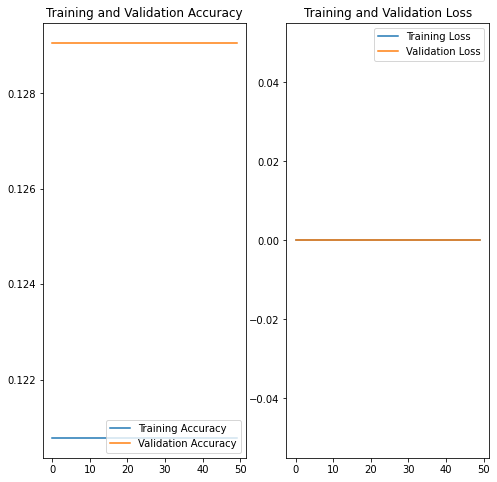

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Here, the class rebalance helped in reducing overfititng of the data and the loss is also reduced, but this also caused to reduce the Acurracy.

Without using the ImageDataGenerator which created data to over fit at high ratio. So, we introduced dropout and ImageDataGenerator which reduced overfitting.

At last we tried Batch Normalization and Augumentation which really helped in carry forward